In [50]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from logger import Logger
from collector import Collector
from enricher import Enricher

In [51]:
# Inicialización de clases
logger = Logger()
df = pd.DataFrame()
logger.info('Main','main','Inicializar clase Logger')
collector = Collector(logger=logger)
enricher = Enricher(logger=logger)

In [52]:
# Obtener datos
df_1 = collector.collector_data()
df_2 = enricher.calcular_kpi(df_1)
df_2

c:\Users\PC\OneDrive\Documentos\Proyecto Integrador V\PIV_2025-1\src\piv\collector.py:71: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')


,fecha,apertura,alto,bajo,cerrar,cierre_ajustado,volumen,dia,mes,año,año_mes,retorno_diario,tasa_variacion_ac,retorno_acumulado,media_movil_5d,volatilidad
249,2024-05-24,467.62,479.85,466.30,478.22,476.48,12012300,24,Mayo,2024,2024-05,0.000000,0.022668,0.000000,0.000,0.000000
248,2024-05-28,476.58,480.86,474.84,479.92,478.18,10175800,28,Mayo,2024,2024-05,0.003555,0.007008,0.003555,0.000,0.000000
247,2024-05-29,474.66,479.85,473.70,474.36,472.64,9226200,29,Mayo,2024,2024-05,-0.011585,-0.000632,-0.008072,0.000,0.000000
246,2024-05-30,471.67,471.73,464.71,467.05,465.35,10735200,30,Mayo,2024,2024-05,-0.015410,-0.009795,-0.023357,0.000,0.000000
245,2024-05-31,465.80,469.12,454.46,466.83,465.13,16919800,31,Mayo,2024,2024-05,-0.000471,0.002211,-0.023817,473.276,6.125253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2025-05-19,628.25,643.00,627.80,640.43,640.43,9592400,19,Mayo,2025,2025-05,0.000141,0.019387,0.339195,648.008,9.034449
3,2025-05-20,636.01,639.35,632.26,637.10,637.10,6743500,20,Mayo,2025,2025-05,-0.005200,0.001714,0.332232,644.222,8.795568
2,2025-05-21,631.79,646.61,630.17,635.50,635.50,11464600,21,Mayo,2025,2025-05,-0.002511,0.005872,0.328886,639.450,3.259693
1,2025-05-22,634.05,643.25,630.71,636.57,636.57,8228400,22,Mayo,2025,2025-05,0.001684,0.003974,0.331124,637.988,2.263000


In [53]:
df_2 = enricher.calcular_kpi(df_1)
df_2.head()

,fecha,apertura,alto,bajo,cerrar,cierre_ajustado,volumen,dia,mes,año,año_mes,retorno_diario,tasa_variacion_ac,retorno_acumulado,media_movil_5d,volatilidad
249,2024-05-24,467.62,479.85,466.30,478.22,476.48,12012300,24,Mayo,2024,2024-05,0.000000,0.022668,0.000000,0.000,0.000000
248,2024-05-28,476.58,480.86,474.84,479.92,478.18,10175800,28,Mayo,2024,2024-05,0.003555,0.007008,0.003555,0.000,0.000000
247,2024-05-29,474.66,479.85,473.70,474.36,472.64,9226200,29,Mayo,2024,2024-05,-0.011585,-0.000632,-0.008072,0.000,0.000000
246,2024-05-30,471.67,471.73,464.71,467.05,465.35,10735200,30,Mayo,2024,2024-05,-0.015410,-0.009795,-0.023357,0.000,0.000000
245,2024-05-31,465.80,469.12,454.46,466.83,465.13,16919800,31,Mayo,2024,2024-05,-0.000471,0.002211,-0.023817,473.276,6.125253


In [54]:
df = df_2[["fecha", "cierre_ajustado"]]
df.set_index('fecha', inplace=True)
df.head()

,cierre_ajustado
fecha,
2024-05-24,476.48
2024-05-28,478.18
2024-05-29,472.64
2024-05-30,465.35
2024-05-31,465.13


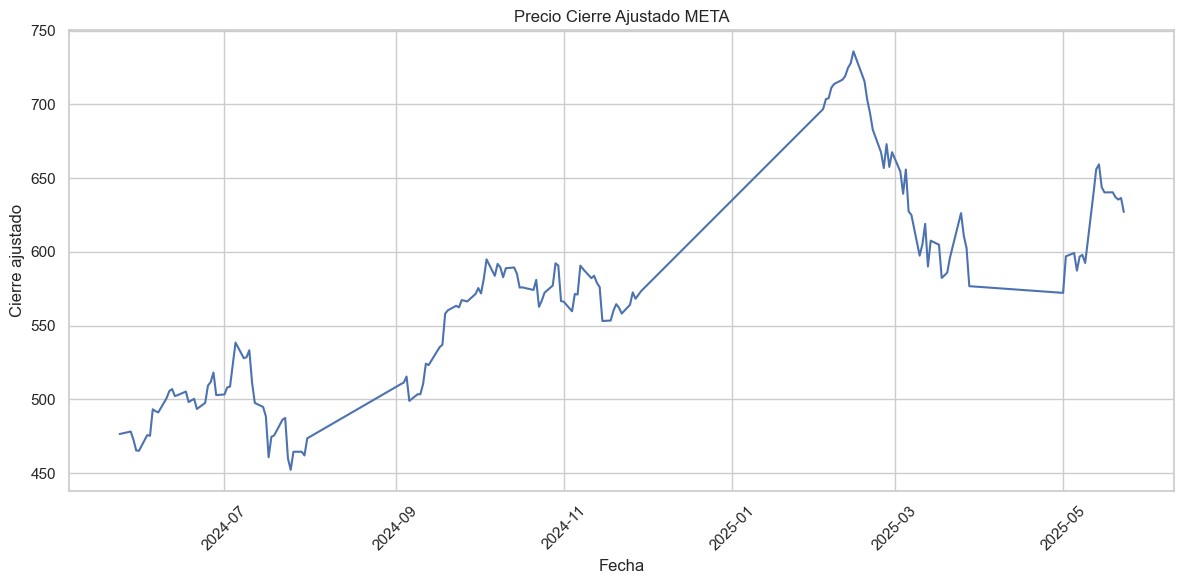

In [55]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.plot(df.index, df['cierre_ajustado'], label='Cierre ajustado')
plt.title('Precio Cierre Ajustado META')
plt.xlabel('Fecha')
plt.ylabel('Cierre ajustado')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

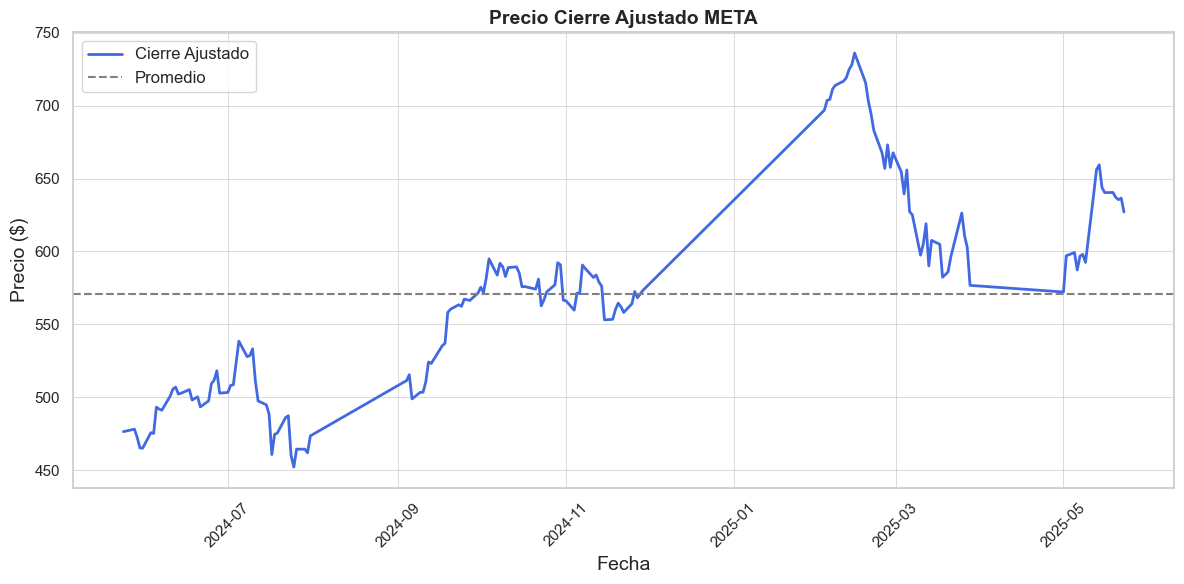

In [56]:
# Visualización con Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['cierre_ajustado'], color='royalblue', linewidth=2, label='Cierre Ajustado')

plt.title('Precio Cierre Ajustado META', fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio ($)', fontsize=14)

plt.axhline(y=df['cierre_ajustado'].mean(), color='gray', linestyle='--', label='Promedio')

plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

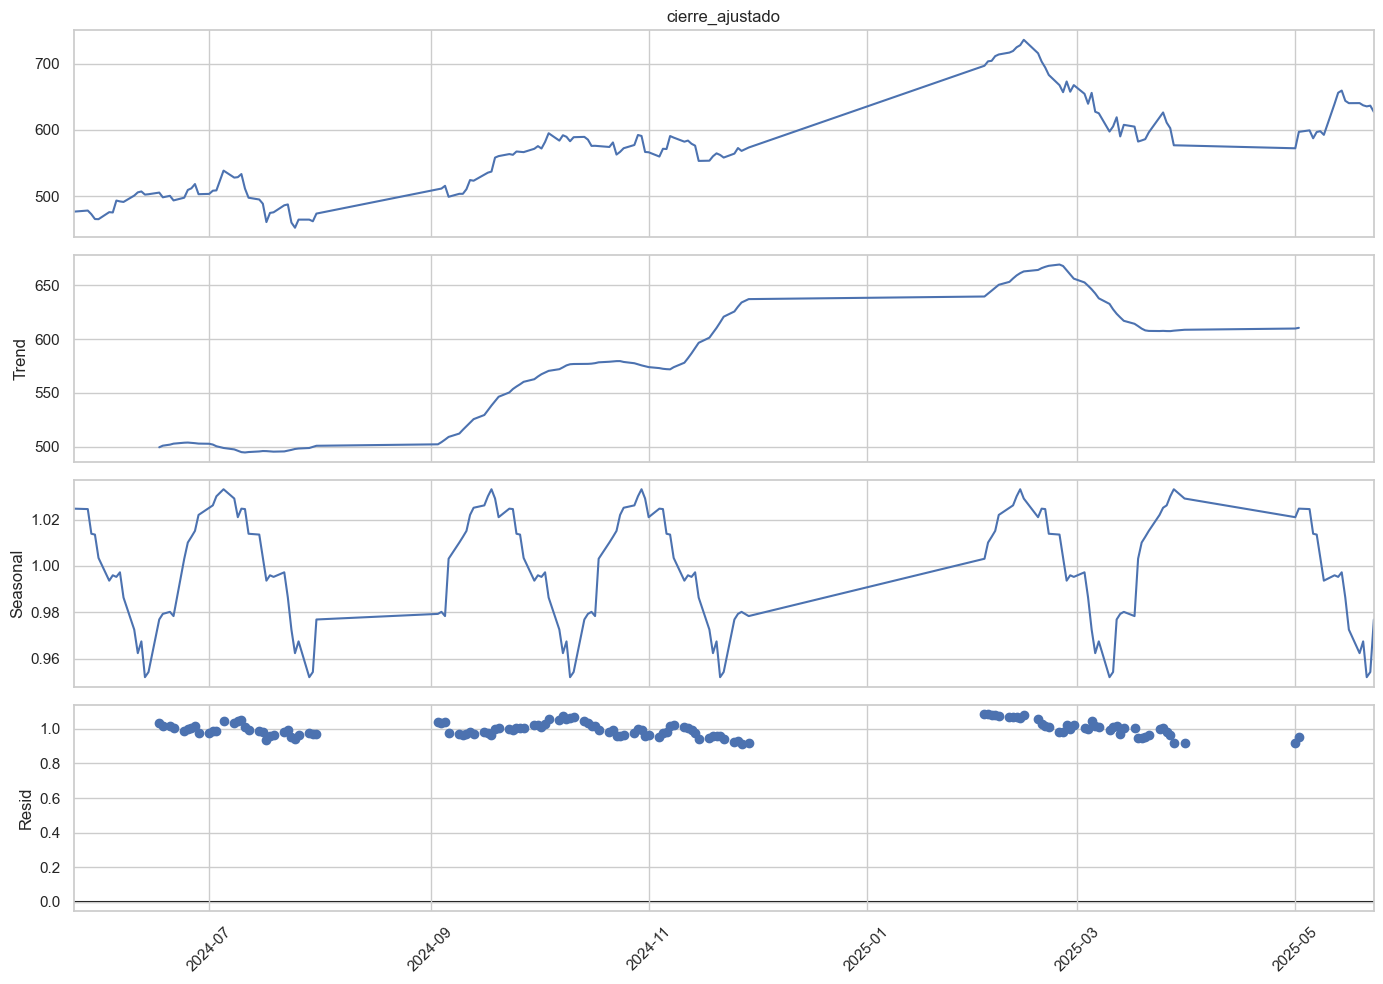

In [57]:
# Descomposición de la serie temporal
decomposition = seasonal_decompose(df['cierre_ajustado'], model='multiplicative', period=30)

# Graficar
fig = decomposition.plot()
fig.set_size_inches(14, 10)  # Tamaño más grande

for ax in fig.axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Mostrar cada 2 meses
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato Año-Mes
    ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas

plt.tight_layout()
plt.show()

In [58]:
result = adfuller(df['cierre_ajustado'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f' {key}: {value}')

if result[1] > 0.05:
    print("\nLa serie NO es estacionaria (p-valor > 0.05)")
else:
    print("\nLa serie es estacionaria (p-valor <= 0.05)")


ADF Statistic: -1.6496711969530558
p-value: 0.4572119109641259
Critical Values:
 1%: -3.470616369591229
 5%: -2.8792214018977655
 10%: -2.57619681359045

La serie NO es estacionaria (p-valor > 0.05)


In [59]:
# Serie diferenciada
df_diff = df['cierre_ajustado'].diff().dropna()
df_diff

fecha
2024-05-28     1.70
2024-05-29    -5.54
2024-05-30    -7.29
2024-05-31    -0.22
2024-06-03    10.62
              ...  
2025-05-19     0.09
2025-05-20    -3.33
2025-05-21    -1.60
2025-05-22     1.07
2025-05-23    -9.51
Name: cierre_ajustado, Length: 165, dtype: float64

In [60]:
# Con la serie diferenciada
result_diff = adfuller(df_diff)
print("ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])
print("Critical Values:")
for key, value in result_diff[4].items():
    print(f' {key}: {value}')

if result_diff[1] > 0.05:
    print("\nLa serie diferenciada NO es estacionaria")
else:
    print("\nLa serie diferenciada es estacionaria")

ADF Statistic: -12.377386082538017
p-value: 5.119183494300909e-23
Critical Values:
 1%: -3.47086589632514
 5%: -2.879330279087651
 10%: -2.57625492712671

La serie diferenciada es estacionaria


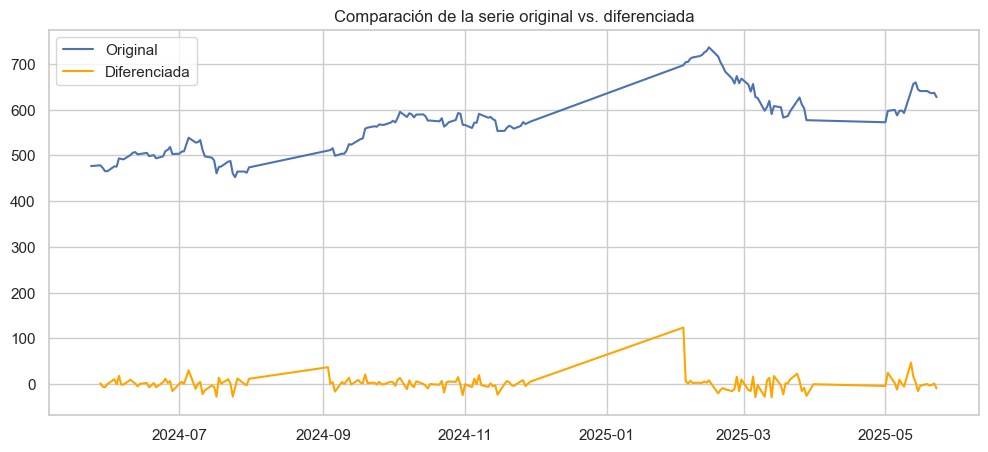

In [61]:
plt.figure(figsize=(12, 5))
plt.plot(df['cierre_ajustado'], label='Original')
plt.plot(df_diff, label='Diferenciada', color='orange')
plt.title('Comparación de la serie original vs. diferenciada')
plt.legend()
plt.grid(True)
plt.show()

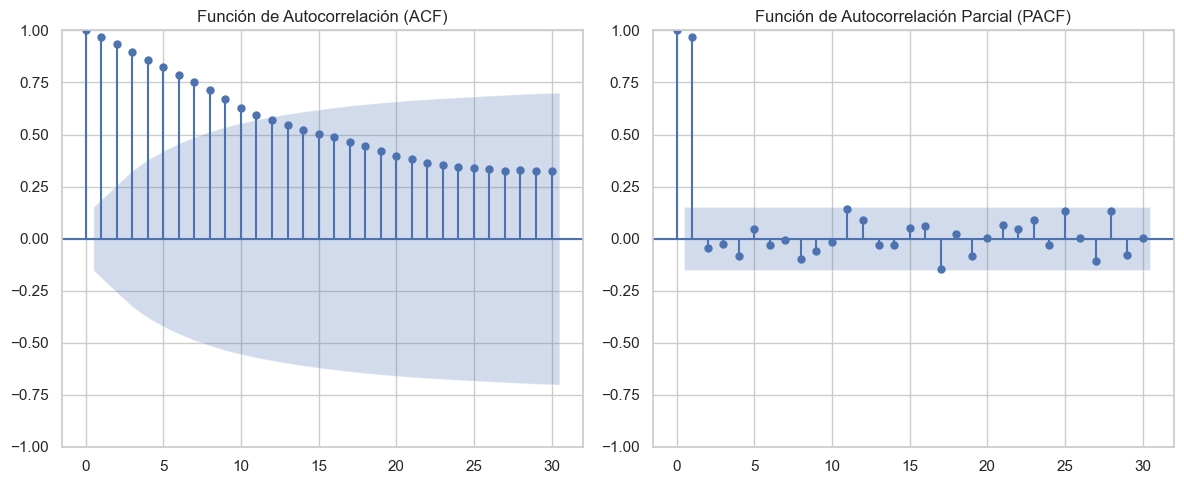

In [62]:
serie = df['cierre_ajustado']
plt.figure(figsize=(12,5))

# ACF
plt.subplot(1, 2, 1)
plot_acf(serie, lags=30, ax=plt.gca())
plt.title('Función de Autocorrelación (ACF)')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(serie, lags=30, ax=plt.gca(), method='ywm')  # ywm = Yule-Walker-MLE
plt.title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

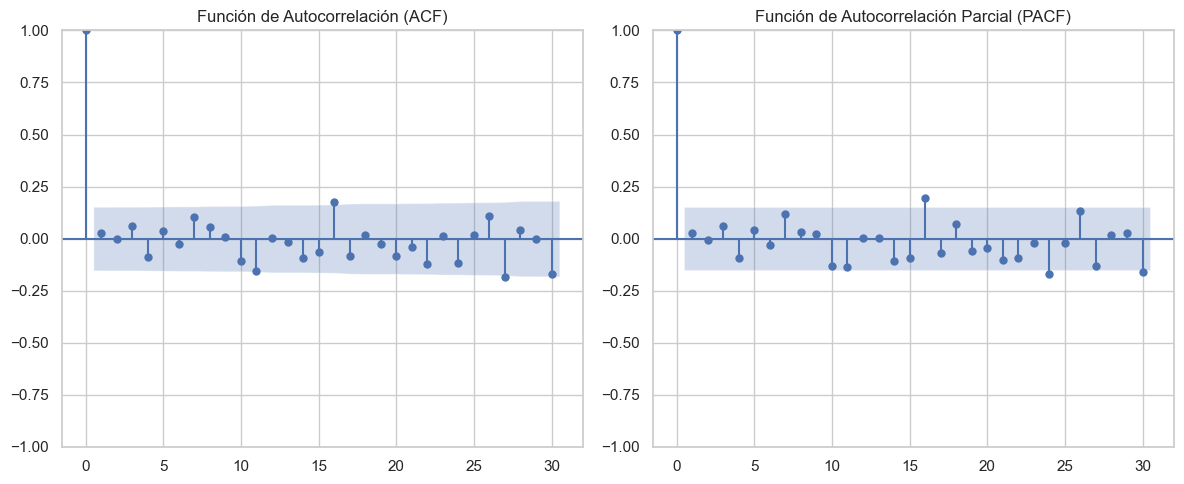

In [63]:
serie = df['cierre_ajustado']

plt.figure(figsize=(12,5))

# ACF
plt.subplot(1, 2, 1)
plot_acf(df_diff, lags=30, ax=plt.gca())
plt.title('Función de Autocorrelación (ACF)')

# PACF
plt.subplot(1, 2, 2)
plot_pacf(df_diff, lags=30, ax=plt.gca(), method='ywm')
plt.title('Función de Autocorrelación Parcial (PACF)')

plt.tight_layout()
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_17004\478368722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA_12'] = df['cierre_ajustado'].rolling(window=12).mean()


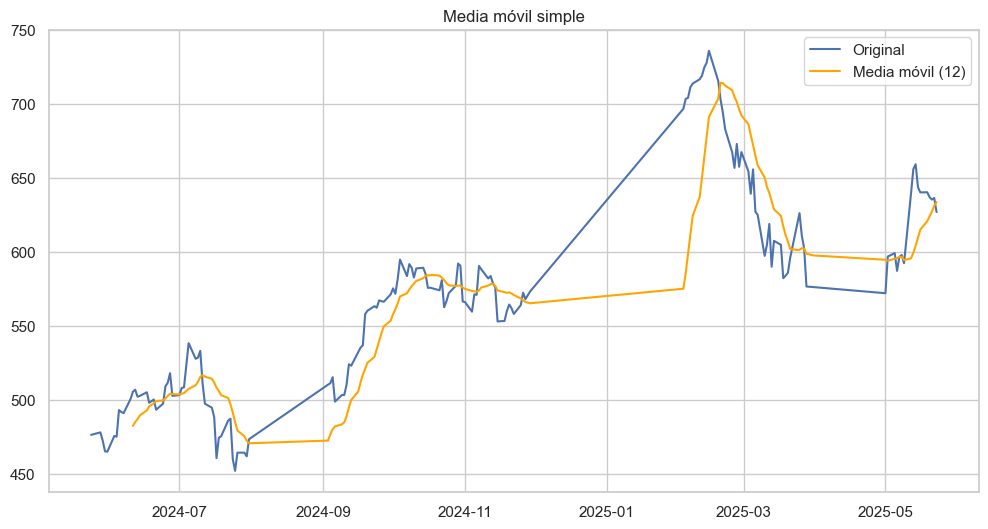

In [64]:
# Suavizado con media móvil simple (ej: ventana de 12 períodos)
df['MA_12'] = df['cierre_ajustado'].rolling(window=12).mean()

plt.figure(figsize=(12,6))
plt.plot(df['cierre_ajustado'], label='Original')
plt.plot(df['MA_12'], label='Media móvil (12)', color='orange')
plt.title('Media móvil simple')
plt.legend()
plt.show()

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Temp\ipykernel_17004\3493777264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SES'] = model_ses.fittedvalues


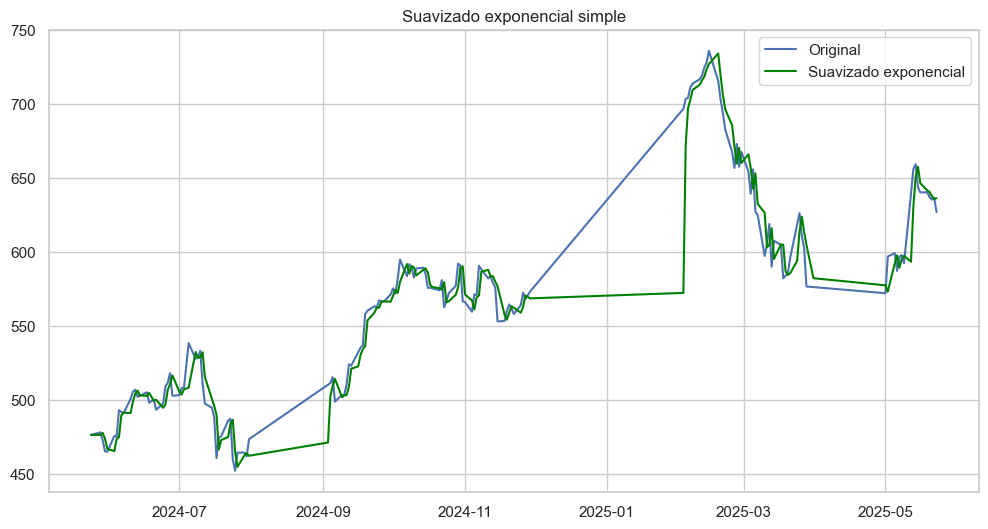

In [65]:
model_ses = SimpleExpSmoothing(df['cierre_ajustado']).fit(smoothing_level=0.8, optimized=False)
df['SES'] = model_ses.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(df['cierre_ajustado'], label='Original')
plt.plot(df['SES'], label='Suavizado exponencial', color='green')
plt.title('Suavizado exponencial simple')
plt.legend()
plt.show()

#### ARIMA (AutoRegressive Integrated Moving Average)

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Temp\ipykernel_17004\1503363040.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

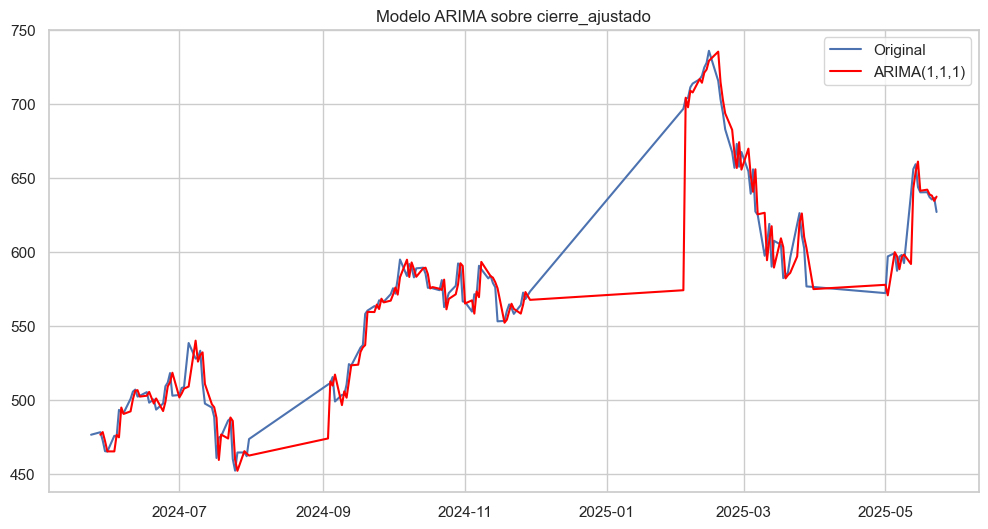

In [66]:
# Ajuste del modelo
model_arima = ARIMA(df['cierre_ajustado'], order=(1,1,1))
result_arima = model_arima.fit()

# Predicción (alineada con el índice original)
pred = result_arima.predict(start=df.index[1], end=df.index[-1], typ='levels')

# Guardar la predicción en el DataFrame
df['ARIMA_pred'] = pred

# Visualización
plt.figure(figsize=(12,6))
plt.plot(df['cierre_ajustado'], label='Original')
plt.plot(df['ARIMA_pred'], label='ARIMA(1,1,1)', color='red')
plt.title('Modelo ARIMA sobre cierre_ajustado')
plt.legend()
plt.show()

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but i

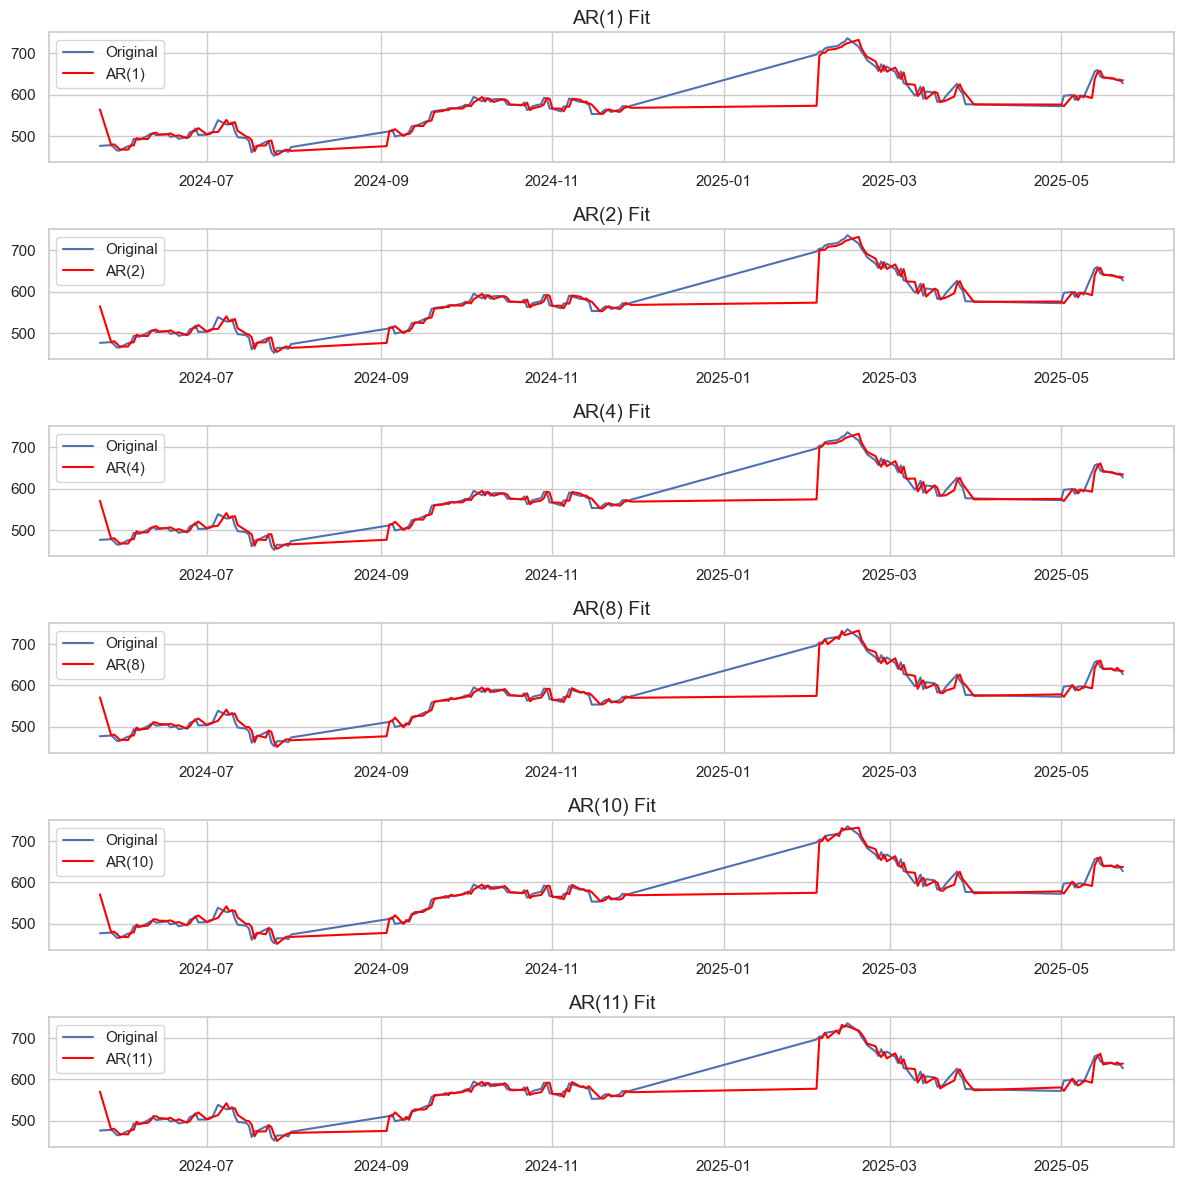

In [67]:
ar_orders = [1, 2, 4, 8, 10, 11]

# Diccionario para guardar modelos ajustados
fitted_model_dict = {}

# Crear subplots para cada valor de p
plt.figure(figsize=(12, 12))

for idx, ar_order in enumerate(ar_orders):
    # Crear y ajustar modelo ARIMA(p,0,0)
    ar_model = ARIMA(df['cierre_ajustado'], order=(ar_order, 0, 0))
    ar_model_fit = ar_model.fit()

    # Guardar el modelo
    fitted_model_dict[ar_order] = ar_model_fit

    # Graficar
    plt.subplot(len(ar_orders), 1, idx + 1)
    plt.plot(df['cierre_ajustado'], label='Original')
    plt.plot(ar_model_fit.fittedvalues, label=f'AR({ar_order})', color='red')
    plt.title(f"AR({ar_order}) Fit", fontsize=14)
    plt.legend()

plt.tight_layout()
plt.show()

In [68]:
for ar_order in ar_orders:
    aic = fitted_model_dict[ar_order].aic
    print(f"AIC para AR({ar_order}): {aic}")

AIC para AR(1): 1380.3348170610718
AIC para AR(2): 1382.0248908968101
AIC para AR(4): 1385.0120246487872
AIC para AR(8): 1388.2588438930015
AIC para AR(10): 1391.41624027229
AIC para AR(11): 1391.0177484293497


In [69]:
print("\n# Comparación de BIC")
for ar_order in ar_orders:
    bic = fitted_model_dict[ar_order].bic
    print(f"BIC para AR({ar_order}): {bic}")


# Comparación de BIC
BIC para AR(1): 1389.6707804261414
BIC para AR(2): 1394.4728420502363
BIC para AR(4): 1403.6839513789264
BIC para AR(8): 1419.378721776567
BIC para AR(10): 1428.7600937325685
BIC para AR(11): 1431.4735896779848


#### SARIMA (Seasonal ARIMA)

c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Temp\ipykernel_17004\1964783244.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SARIMA_pred'] = result_sarima.predict(


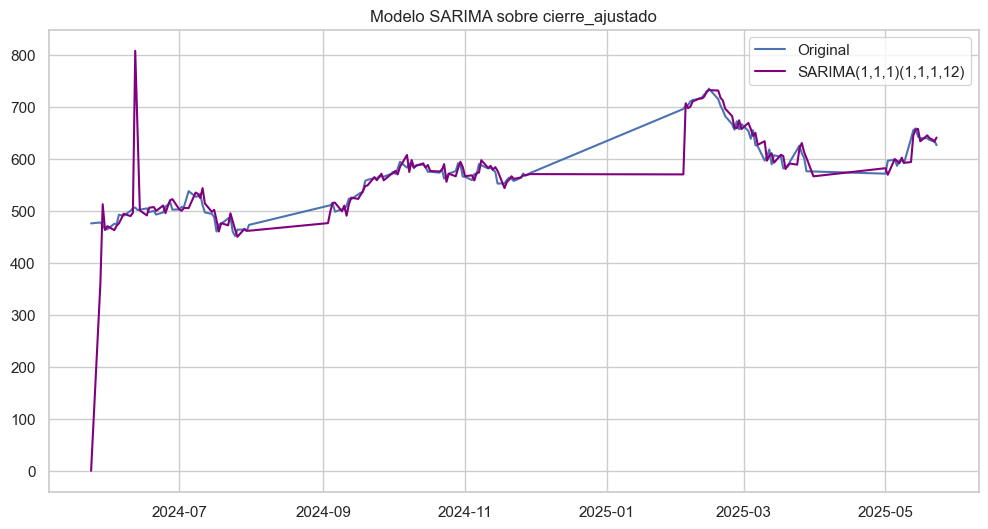

In [70]:
model_sarima = SARIMAX(
    df['cierre_ajustado'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result_sarima = model_sarima.fit()

# Predicción usando el índice temporal
df['SARIMA_pred'] = result_sarima.predict(
    start=df.index[0],
    end=df.index[-1],
    typ='levels'
)

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(df['cierre_ajustado'], label='Original')
plt.plot(df['SARIMA_pred'], label='SARIMA(1,1,1)(1,1,1,12)', color='purple')
plt.title('Modelo SARIMA sobre cierre_ajustado')
plt.legend()
plt.show()


c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


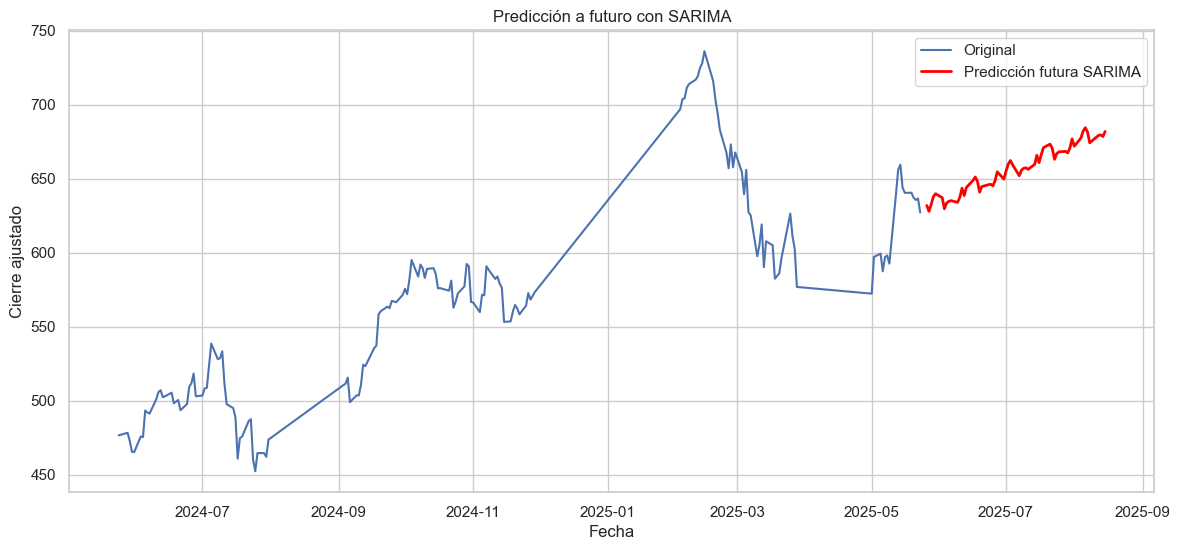

In [71]:
forecast = result_sarima.forecast(steps=60)

# Crear índice futuro (60 días hábiles a partir del día siguiente al último de la serie)
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=60, freq='B')

# Crear la serie con índice de fechas
forecast_series = pd.Series(forecast.values, index=future_index)

# Graficar
plt.figure(figsize=(14,6))
plt.plot(df['cierre_ajustado'], label='Original')
plt.plot(forecast_series, label='Predicción futura SARIMA', color='red', linewidth=2)
plt.title('Predicción a futuro con SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Cierre ajustado')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Función de evaluación de modelos
def evaluar_modelos(df, real_col='cierre_ajustado', pred_cols=None):
    if pred_cols is None:
        pred_cols = ['MA_12', 'SES', 'ARIMA_pred', 'SARIMA_pred']  # Asegúrate de que estas columnas existen en df

    resultados = []

    for col in pred_cols:
        if col not in df.columns:
            print(f"Columna '{col}' no encontrada en DataFrame. Se omite.")
            continue

        valid = df[[real_col, col]].dropna()
        if valid.empty:
            print(f"No hay datos válidos para comparar en '{col}'.")
            continue

        y_true = valid[real_col]
        y_pred = valid[col]

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        resultados.append({
            'Modelo': col,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'R2': r2
        })

    return pd.DataFrame(resultados).set_index('Modelo').round(2)


In [73]:
# Evaluar los modelos aplicados sobre 'cierre_ajustado'
resultados_metricas = evaluar_modelos(df, real_col='cierre_ajustado', pred_cols=['MA_12', 'SES', 'ARIMA_pred', 'SARIMA_pred'])

# Mostrar los resultados en una tabla
print(resultados_metricas)

               MAE   RMSE  MAPE (%)    R2
Modelo                                   
MA_12        21.96  30.75      3.68  0.78
SES           9.58  15.50      1.65  0.95
ARIMA_pred    9.07  15.06      1.57  0.95
SARIMA_pred  16.43  49.01      3.07  0.48


c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\PC\AppData\Local\Temp\ipykernel_17004\366900730.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

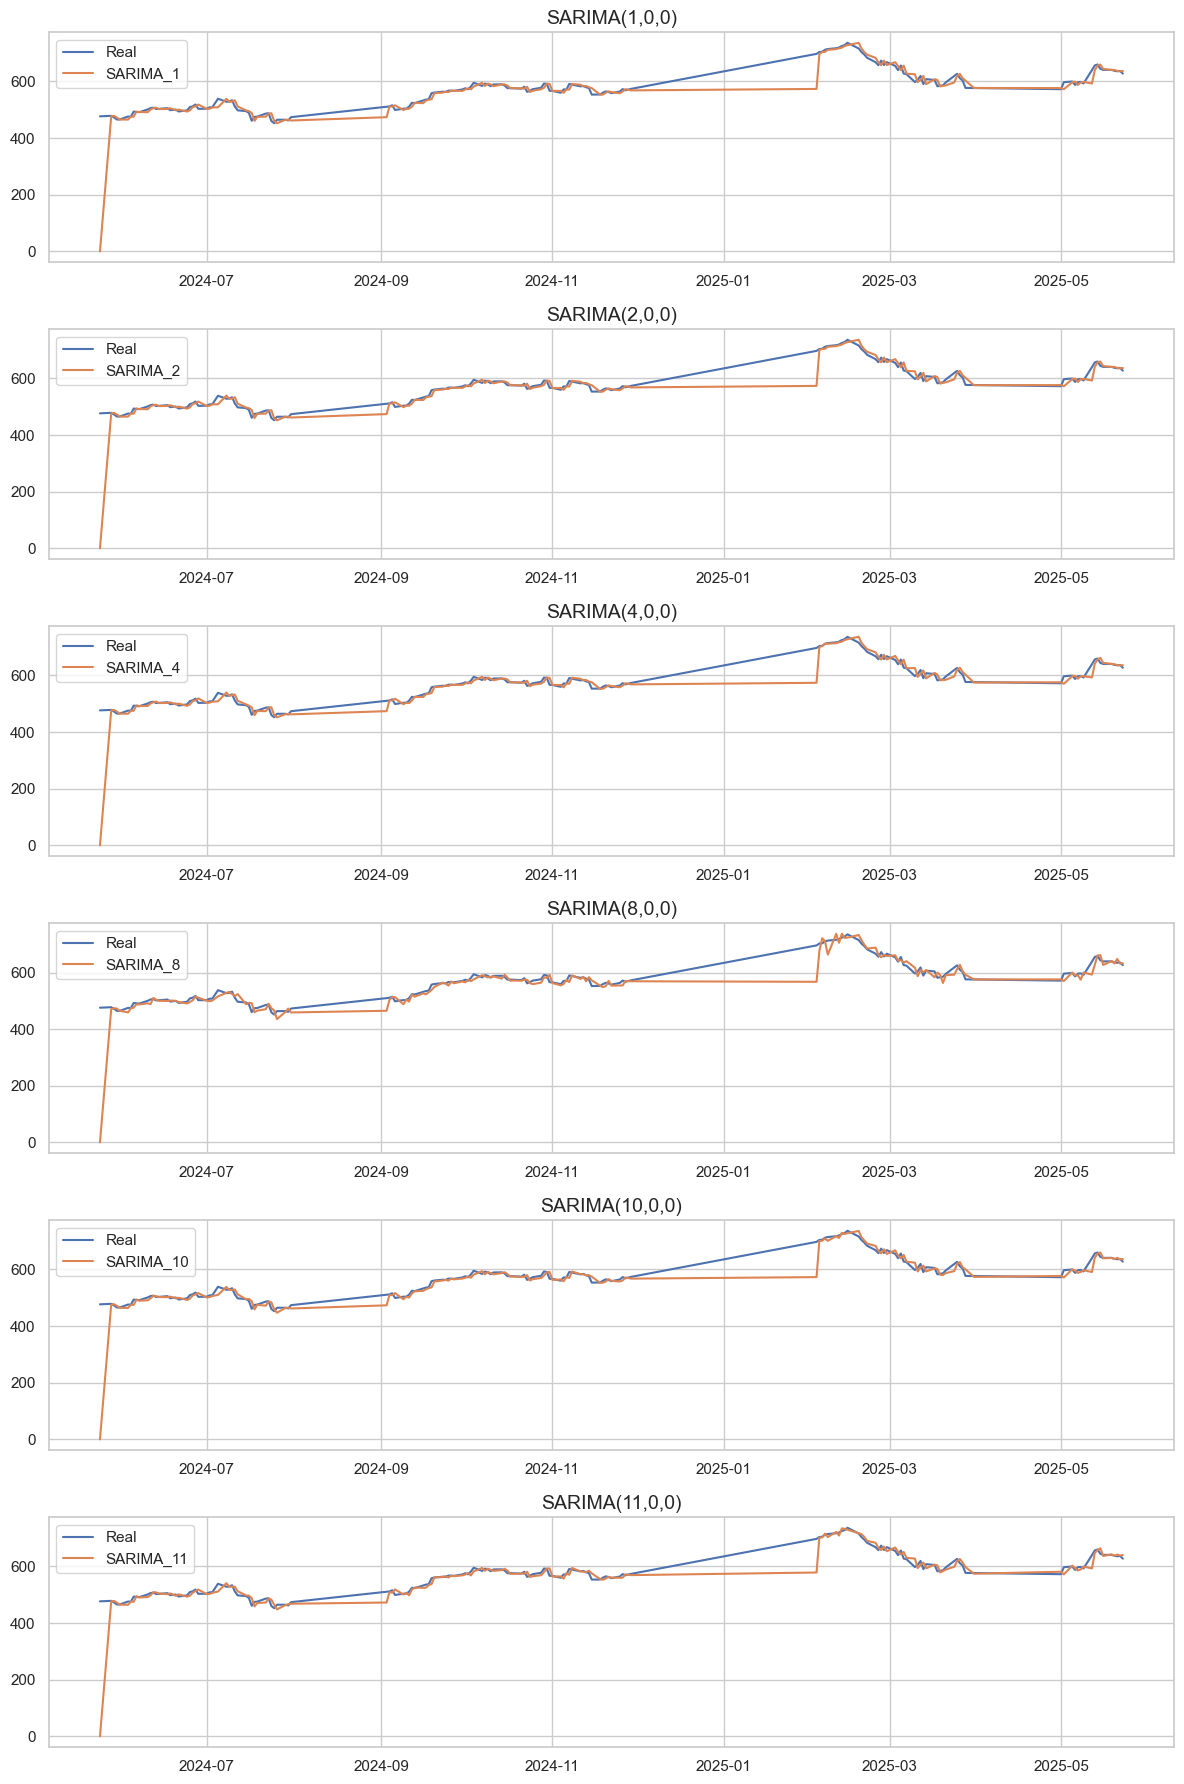

In [74]:
plt.figure(figsize=(12, 18))
sarima_orders = [1, 2, 4, 8, 10, 11]
fitted_model_sarima = {}

for idx, sarima_order in enumerate(sarima_orders):
    sarima_model = SARIMAX(df['cierre_ajustado'], order=(sarima_order, 0, 0))
    sarima_model_fit = sarima_model.fit(disp=False)
    
    fitted_model_sarima[sarima_order] = sarima_model_fit
    col_name = f'SARIMA_{sarima_order}'
    df[col_name] = sarima_model_fit.fittedvalues

    # Gráfico
    plt.subplot(len(sarima_orders), 1, idx + 1)
    plt.plot(df['cierre_ajustado'], label='Real')
    plt.plot(df[col_name], label=col_name)
    plt.title(f'SARIMA({sarima_order},0,0)', fontsize=14)
    plt.legend()

plt.tight_layout()

In [75]:
for sarima_order in sarima_orders:
    aic = fitted_model_sarima[sarima_order].aic
    print(f'AIC para SARIMA({sarima_order},0,0): {aic:.2f}')

AIC para SARIMA(1,0,0): 1384.31
AIC para SARIMA(2,0,0): 1386.16
AIC para SARIMA(4,0,0): 1389.52
AIC para SARIMA(8,0,0): 1437.54
AIC para SARIMA(10,0,0): 1404.77
AIC para SARIMA(11,0,0): 1396.73


In [76]:
for sarima_order in sarima_orders:
    bic = fitted_model_sarima[sarima_order].bic
    print(f'BIC para SARIMA({sarima_order},0,0): {bic:.2f}')

BIC para SARIMA(1,0,0): 1390.53
BIC para SARIMA(2,0,0): 1395.49
BIC para SARIMA(4,0,0): 1405.08
BIC para SARIMA(8,0,0): 1465.55
BIC para SARIMA(10,0,0): 1439.01
BIC para SARIMA(11,0,0): 1434.08
